In [47]:
import sys
import numpy as np
np.set_printoptions(suppress=True, precision=4)
import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.4f}'.format
import seaborn as sns
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objs as go
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss, make_scorer, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, MultiLabelBinarizer
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from sklearn.metrics import log_loss, make_scorer
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.metrics import BinaryCrossentropy, Precision, Recall, AUC
from methods import *
import torch
import pickle, os
import skopt
from skopt import BayesSearchCV, gp_minimize
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
import shutil
import time
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
print('done')

done


In [2]:
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
print('done')

done


# Binary classification based on "backdoor_label" column

Using diffs
train shapes: (907, 20) (907,)
test shapes: (101, 20) (101,)
CE loss (test) = 0.5566924444519648
done


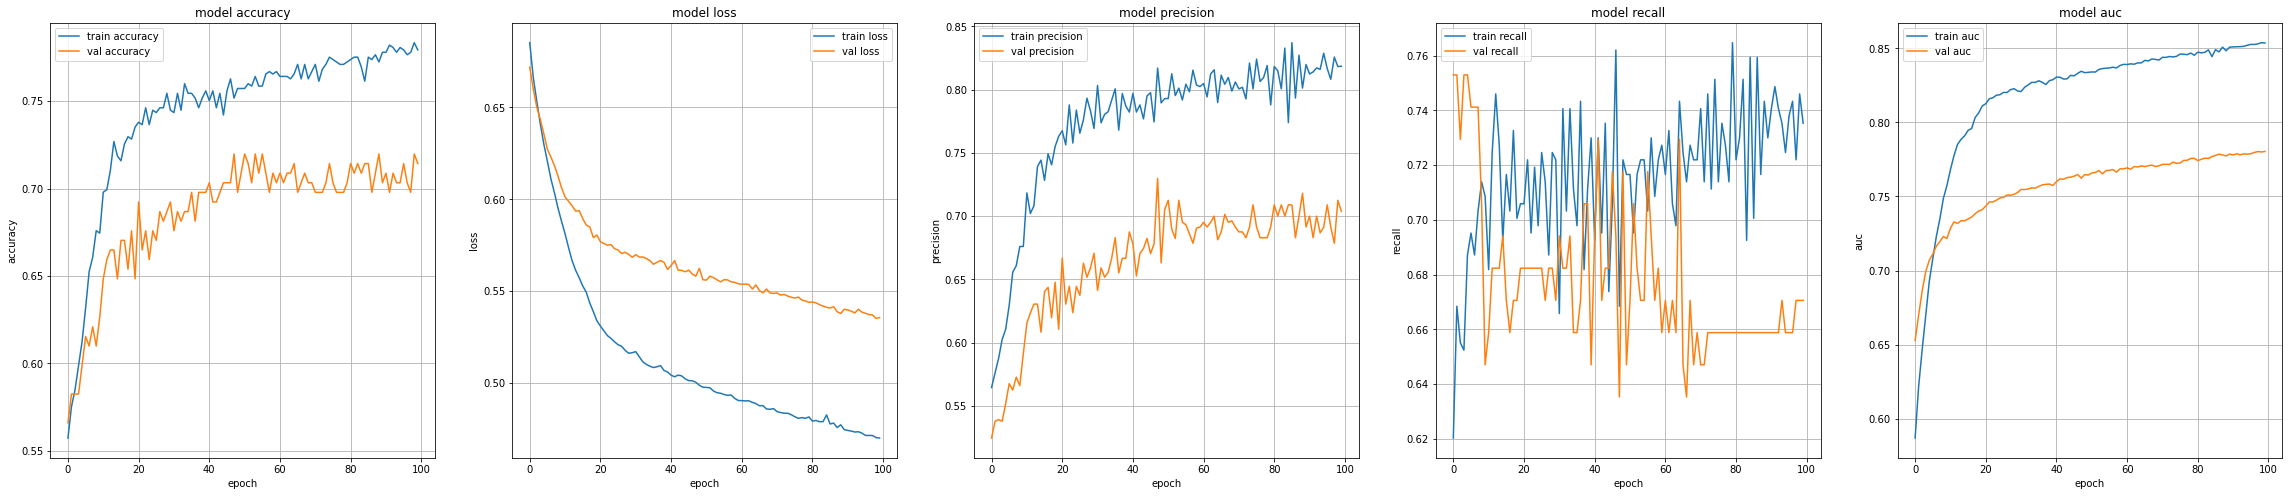

In [45]:
use_arch = True
path_train = r'confusion-reports\ics_fc\round4-train-dataset\round4-train-dataset_fc_synthetic_polygon-all-gray_filters_0-1007.csv'
X, y = read_features(path_train, trigger_type_aux_str=None, arch=None, data='diffs', label_type='binary', append_arch=use_arch, arch_one_hot=use_arch)
# X_0, y_0 = read_features(path_train, trigger_type_aux_str=None, arch=None, data='diffs', label_type='backdoor_code_0', append_arch=use_arch, arch_one_hot=use_arch)
# X_1, y_1 = read_features(path_train, trigger_type_aux_str=None, arch=None, data='diffs', label_type='backdoor_code_0', append_arch=use_arch, arch_one_hot=use_arch)

percent_training = 0.9
n_samples = X.shape[0]
# np.random.seed(int(time.time()))
np.random.seed(666)
indexes_train = np.random.choice(n_samples, int(n_samples * percent_training), replace=False).tolist()
indexes_test = [i for i in range(n_samples) if i not in indexes_train]

X_train, y_train, X_test, y_test = X[indexes_train, :], y[indexes_train], X[indexes_test, :], y[indexes_test]
print('train shapes:', X_train.shape, y_train.shape)
print('test shapes:', X_test.shape, y_test.shape)

model = Sequential()
model.add(Dense(10, input_dim=X.shape[1], activation='relu')) # logistic regression: only one dense layer with 7 units, input_size and softmax
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2)
y_pred = model.predict(X_test)

ce_loss = 0.0
for i in range(y_pred.shape[0]):
    t, p = y_test[i], y_pred[i]
    ce_loss += -(t * np.log(p) + (1. - t) * np.log(1. - p))
ce_loss = ce_loss[0] / y_pred.shape[0]
print(f'CE loss (test) = {ce_loss}\ndone')

the_time = datetime.now().strftime('%Y-%m-%d_%Hh%Mm%Ss')
folder = fr'neural_networks_all_backdoors_round_4/{the_time}_test-CE={ce_loss:.3f}_input={X.shape[1]}_train-count={len(indexes_train)}_test-count={len(indexes_test)}'
keras_save(model, folder, name='model')

L, C = 1, 5
plt.figure(figsize=(40,8)).patch.set_color('white')

plt.subplot(L,C,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(L,C,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(L,C,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(L,C,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(L,C,5)
plt.plot(history.history['auc'], label='train auc')
plt.plot(history.history['val_auc'], label='val auc')
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

# Neural Network with independent Bernoulli distributions

Using diffs
train shapes: (907, 20) (907, 7)
test shapes: (101, 20) (101, 7)


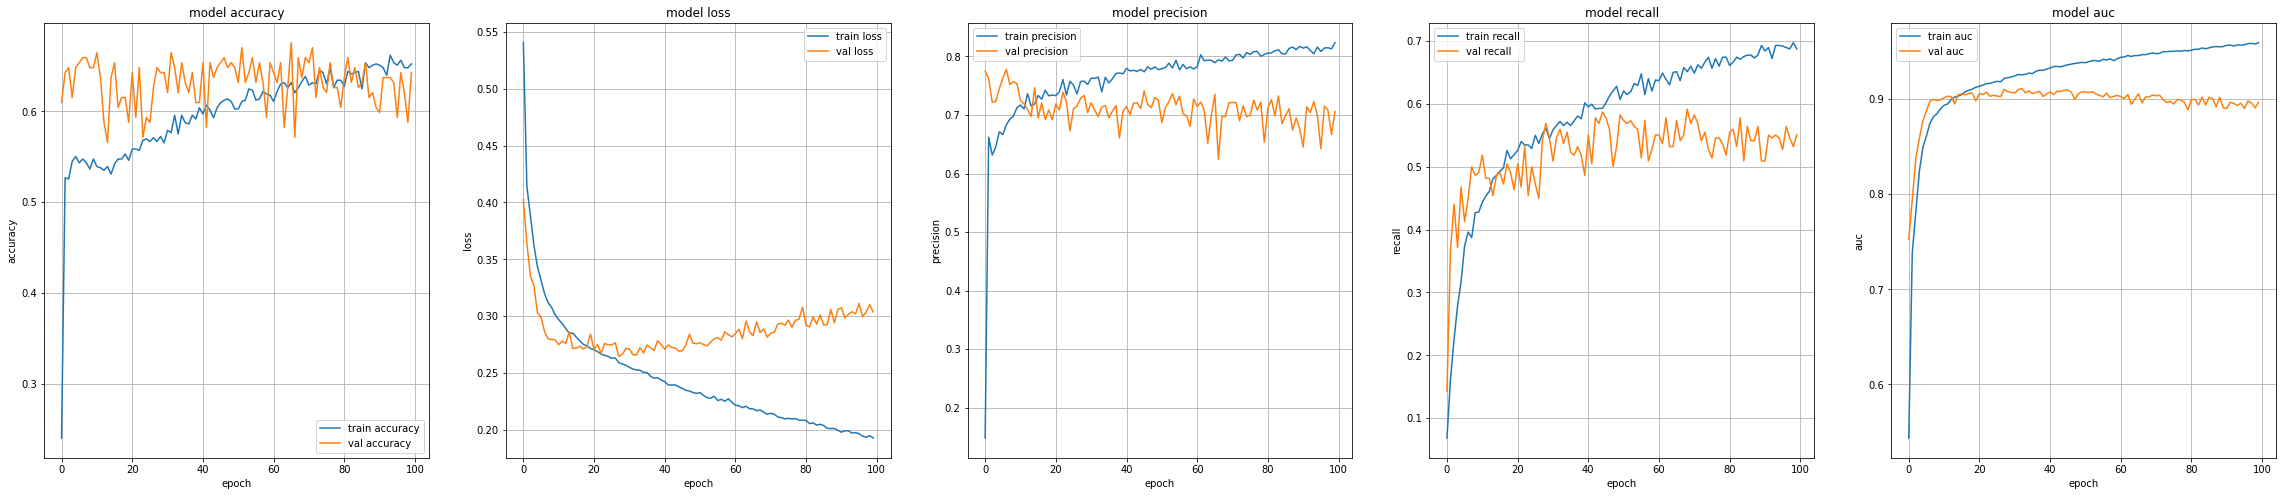

CE loss (test) = 0.541049202185232
done


In [86]:
use_arch = True
path_train = r'confusion-reports\ics_fc\round4-train-dataset\round4-train-dataset_fc_synthetic_polygon-all-gray_filters_0-1007.csv'
X, y = read_features(path_train, trigger_type_aux_str=None, arch=None, data='diffs', label_type='backdoor_code_2', append_arch=use_arch, arch_one_hot=use_arch)
y = MultiLabelBinarizer().fit_transform(y)
percent_training = 0.9
n_samples = X.shape[0]
np.random.seed(int(time.time()))
# np.random.seed(666)
indexes_train = np.random.choice(n_samples, int(n_samples * percent_training), replace=False).tolist()
indexes_test = [i for i in range(n_samples) if i not in indexes_train]

X_train, y_train, X_test, y_test = X[indexes_train, :], y[indexes_train], X[indexes_test, :], y[indexes_test]
print('train shapes:', X_train.shape, y_train.shape)
print('test shapes:', X_test.shape, y_test.shape)

model = Sequential()
model.add(Dense(50, input_dim=X.shape[1], activation='relu')) # logistic regression: only one dense layer with 7 units, input_size and softmax
model.add(Dense(25, activation='relu'))
model.add(Dense(7, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
history = model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0, validation_split=0.2)
y_pred = model.predict(X_test)

# the_time = datetime.now().strftime('%Y-%m-%d_%Hh%Mm%Ss')
# folder = fr'neural_networks_all_backdoors_round_4/{the_time}_test-CE={ce_loss:.3f}_input={X.shape[1]}_train-count={len(indexes_train)}_test-count={len(indexes_test)}'
# keras_save(model, folder, name='model')

L, C = 1, 5
plt.figure(figsize=(40,8)).patch.set_color('white')

plt.subplot(L,C,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(L,C,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(L,C,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(L,C,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(L,C,5)
plt.plot(history.history['auc'], label='train auc')
plt.plot(history.history['val_auc'], label='val auc')
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

ce_loss = 0.0
print_messages = False
for i in range(y_pred.shape[0]):
    t, p = y_test[i], y_pred[i]
    t = 1 if t[1:].sum() > 0 else 0
    v = sorted(enumerate(p), key=lambda x: -x[1])
    label, proba = v[0]
    if label == 0:
        proba = 1 - proba
    if print_messages:
        print(t, '\n', p)
        print('true binary class:', t)
        print(f'predicted proba: {p}')
        print()
    ce_loss += -(t * np.log(proba) + (1. - t) * np.log(1. - proba))
ce_loss = ce_loss / y_pred.shape[0]
print(f'CE loss (test) = {ce_loss}\ndone')